# Benchmark QRT

This notebook illustrates a simple benchmark example that should help novice participants to start the competition.

## Used libraries

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel


## Loading data

The x_train and x_test sets are composed of 35 columns.

The target of this challenge is `TARGET` and corresponds to the price change for daily futures contracts of 24H electricity baseload.

Electricity prices can be quite volatile, so we have chosen the Spearman rank correlation as a robust measure for the challenge.

Both x_train and y_train have an ID column. This is a unique ID. 

You will notice some columns have missing values.


In [3]:
x_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('y_train.csv')
x_test = pd.read_csv('x_test.csv')


In [4]:
x_test

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1115,241,FR,0.340083,-0.433604,-0.423521,0.423521,0.165333,0.519419,-0.165333,...,-0.222525,-0.513180,-0.182048,-0.982546,-0.876632,0.880491,0.692242,0.569419,-0.029697,-0.929256
1,1202,1214,FR,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,...,0.857739,-0.340595,-0.301094,-0.759816,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086
2,1194,1047,FR,0.795540,0.721954,1.179158,-1.179158,1.620928,0.666901,-1.620928,...,0.447967,0.796475,-0.367248,0.376055,-0.483363,0.865138,0.120079,-1.485642,-0.326450,-0.349747
3,1084,1139,FR,0.172555,-0.723427,-0.044539,0.044539,NaN,-0.205276,NaN,...,-0.561295,-0.542606,-0.013291,-0.791119,-0.894309,0.239153,0.457457,-0.746863,2.262654,0.642069
4,1135,842,FR,0.949714,0.420236,0.617391,-0.617391,0.608561,-0.240856,-0.608561,...,0.503567,-0.230291,-0.609203,-0.744986,-1.196282,0.176557,0.312557,-2.219626,-0.509272,-0.488341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,879,213,DE,0.267684,-0.901332,0.749769,-0.749769,1.198565,-1.614458,-1.198565,...,-1.057186,1.591562,-0.284628,2.272121,1.647899,-0.838634,-0.463684,-1.071829,0.720641,-1.842072
650,673,943,DE,1.389207,1.466549,0.661778,-0.661778,0.610986,-1.934012,-0.610986,...,1.055349,0.155454,-0.168436,1.290495,2.199105,-0.329098,-1.172309,-1.290355,-0.897009,-0.925825
651,1641,261,FR,1.377650,1.781671,0.557006,-0.557006,-0.326698,-1.462676,0.326698,...,1.824478,-0.825759,-0.266881,-1.247165,-0.666308,-0.807636,-1.260777,0.931572,0.151169,0.474347
652,712,1082,DE,1.232202,1.971074,0.537247,-0.537247,-1.109420,-1.464287,1.109420,...,1.964292,-0.145241,-0.358861,0.195383,-0.103433,1.352906,-0.485161,0.995363,-0.152287,2.067306


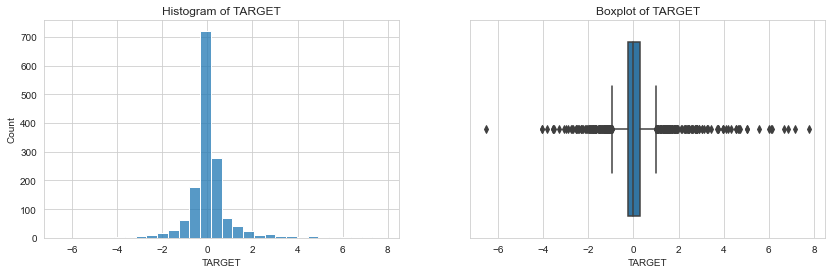

In [5]:
sns.set_style("whitegrid")

# Function to create a histogram and a boxplot for the target variable
def plot_distribution(data, feature_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    
    sns.histplot(data[feature_name], bins=30, kde=False, ax=ax1)
    ax1.set_title(f'Histogram of {feature_name}')
    
    sns.boxplot(x=feature_name, data=data, ax=ax2)
    ax2.set_title(f'Boxplot of {feature_name}')
    
    plt.show()

plot_distribution(y_train, 'TARGET')


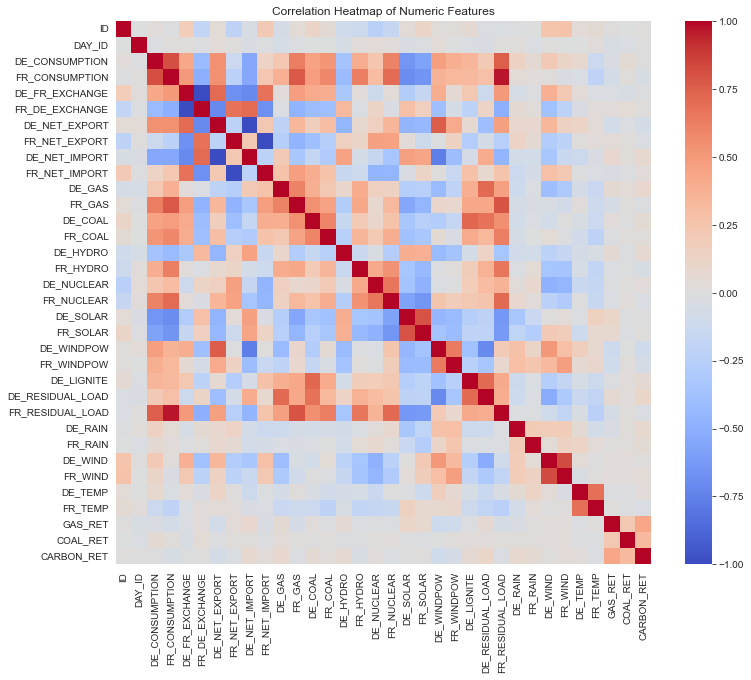

In [6]:
x_train_numeric = x_train.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(12, 10))
sns.heatmap(x_train_numeric.corr(), cmap='coolwarm', fmt=".2f", annot=False)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


## Model and local score

We chose a simple linear regression as the challenges' benchmark. The missing values are simply filled with 0, and the COUNTRY column is dropped. 

**Ideas of improvements**: This challenge will test your knowledge of modeling techniques and feature engineering, as well as proper EDA and validation. Knowledge about the fundamental price drivers of electricity in each country will also be useful. The dataset is small, so you will need to be careful not to overfit to the train data.


In [7]:
y_train = y_train['TARGET']

# Separate features and target from the training data
X = x_train.drop(columns=['ID'])
Xt = x_train.drop(['COUNTRY'], axis=1).fillna(0)
X = X.drop(["DAY_ID"], axis=1)
X = X.drop(["COAL_RET", "GAS_RET", "CARBON_RET", "FR_DE_EXCHANGE","DE_RESIDUAL_LOAD","FR_GAS","FR_COAL","FR_HYDRO","FR_SOLAR","FR_WINDPOW","FR_RAIN","FR_WIND","FR_TEMP"], axis=1)
X = X.drop(["DE_SOLAR",'FR_NET_EXPORT', 'DE_NET_EXPORT', 'FR_NET_IMPORT', "DE_CONSUMPTION", "FR_CONSUMPTION","DE_COAL", "DE_RAIN", "DE_GAS", "DE_WIND","DE_TEMP", 'DE_LIGNITE', "DE_NUCLEAR", 'FR_RESIDUAL_LOAD', 'DE_WINDPOW'], axis=1)
Y = y_train

# Define categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

#preprocessing pipelines for both numeric and categorical data
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

# Combine the numeric and categorical transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)



In [8]:
# Define a custom scoring function based on Spearman's correlation
def spearman_scoring_function(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

# Make a custom scorer from the scoring function
spearman_scorer = make_scorer(spearman_scoring_function, greater_is_better=True)

pipeline = make_pipeline(preprocessor, GradientBoostingRegressor(random_state=42))

param_grid = {
    'gradientboostingregressor__n_estimators': [100, 200, 300],
    'gradientboostingregressor__learning_rate': [0.01, 0.05, 0.1],
    'gradientboostingregressor__max_depth': [4, 5],
    'gradientboostingregressor__min_samples_split': [2, 4],
    'gradientboostingregressor__min_samples_leaf': [1, 3],
    'gradientboostingregressor__max_features': ['sqrt', 'log2', None]
}


# Perform GridSearchCV with the custom scorer and the pipeline
grid_search_spearman = GridSearchCV(estimator=pipeline,
                                    param_grid=param_grid,
                                    scoring=spearman_scorer,  
                                    n_jobs=-1,
                                    cv=5,
                                    verbose=1)

# Fit the GridSearchCV object to the training data
grid_search_spearman.fit(x_train, y_train)

# The best estimator from the grid search
best_estimator_spearman = grid_search_spearman.best_estimator_

# perform feature selection based on the best estimator
feature_selection = SelectFromModel(best_estimator_spearman.named_steps['gradientboostingregressor'], threshold='mean')

# The best combination of parameters found
best_params_spearman = grid_search_spearman.best_params_

# The best Spearman's correlation score achieved during the grid search
best_spearman_score = grid_search_spearman.best_score_

# The best estimator from the grid search
best_estimator_spearman = grid_search_spearman.best_estimator_

# Print out the best parameters and the best score
print("Best parameters for optimizing Spearman's correlation:", best_params_spearman)
print("Best Spearman's correlation score from grid search:", best_spearman_score)



Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for optimizing Spearman's correlation: {'gradientboostingregressor__learning_rate': 0.05, 'gradientboostingregressor__max_depth': 4, 'gradientboostingregressor__max_features': None, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__min_samples_split': 4, 'gradientboostingregressor__n_estimators': 300}
Best Spearman's correlation score from grid search: 0.19476896412218575


In [ ]:
y_test = pd.read_csv('y_test.csv')
y_pred = grid_search_spearman.predict(x_test)

print((100 * spearmanr(y_pred, y_test).correlation))

In [13]:
for param, value in best_params_spearman.items():
    print(f"The best {param} is: {value}")

The best gradientboostingregressor__learning_rate is: 0.01
The best gradientboostingregressor__max_depth is: 5
The best gradientboostingregressor__max_features is: None
The best gradientboostingregressor__min_samples_leaf is: 1
The best gradientboostingregressor__min_samples_split is: 2
The best gradientboostingregressor__n_estimators is: 200
The best gradientboostingregressor__subsample is: 1.0


In [37]:
for param, value in best_params_spearman.items():
    print(f"The best {param} is: {value}")

The best gradientboostingregressor__learning_rate is: 0.05
The best gradientboostingregressor__max_depth is: 4
The best gradientboostingregressor__max_features is: None
The best gradientboostingregressor__min_samples_leaf is: 1
The best gradientboostingregressor__min_samples_split is: 4
The best gradientboostingregressor__n_estimators is: 300


In [39]:
optimized_model = GradientBoostingRegressor(
    n_estimators=best_params_spearman['gradientboostingregressor__n_estimators'],
    learning_rate=best_params_spearman['gradientboostingregressor__learning_rate'],
    max_depth=best_params_spearman['gradientboostingregressor__max_depth'],
    min_samples_split=best_params_spearman['gradientboostingregressor__min_samples_split'],
    min_samples_leaf=best_params_spearman['gradientboostingregressor__min_samples_leaf'],
    subsample=1,
    max_features=best_params_spearman['gradientboostingregressor__max_features'],
    random_state=42
)

# Assuming you have a preprocessor set up from previous steps
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('optimized_model', optimized_model)
])

# Fit the pipeline on the full training data
pipeline.fit(X, Y) 

x_test_pred = pipeline.predict(x_test)

#spearman_corr = spearmanr(Y, x_test_pred)

#print(f"Spearman correlation: {spearman_corr.correlation}")

## Combined Models

### Split

In [33]:
# Split the data for France
X_train_france = X[X['COUNTRY'] == 'FR']
y_train_france = Y[X['COUNTRY'] == 'FR']

# Split the data for Germany
X_train_germany = X[X['COUNTRY'] == 'DE']
y_train_germany = Y[X['COUNTRY'] == 'DE']


### Grid search France

In [34]:
# Define a custom scoring function based on Spearman's correlation
def spearman_scoring_function(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

# Make a custom scorer from the scoring function
spearman_scorer = make_scorer(spearman_scoring_function, greater_is_better=True)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('FR', GradientBoostingRegressor(random_state=42))
])
param_grid = {
    'FR__n_estimators': [100, 200, 300],  
    'FR__max_depth': [3, 4, 5],  
    'FR__min_samples_split': [2, 4], 
    'FR__min_samples_leaf': [1, 3, 5],
    'FR__learning_rate': [0.01, 0.05, 0.1],  
    'FR__max_features': ['sqrt', 'log2', None]
}
   


# Perform GridSearchCV with the custom scorer and the pipeline
grid_search_spearman = GridSearchCV(estimator=pipeline,
                                    param_grid=param_grid,
                                    scoring=spearman_scorer,  
                                    n_jobs=-1,
                                    cv=5,
                                    verbose=1)

# Fit the GridSearchCV object to the training data
grid_search_spearman.fit(X_train_france, y_train_france)

# The best combination of parameters found
best_params_spearman_fr = grid_search_spearman.best_params_

# The best Spearman's correlation score achieved during the grid search
best_spearman_score_fr = grid_search_spearman.best_score_

# The best estimator from the grid search
best_estimator_spearman_fr = grid_search_spearman.best_estimator_

# Print out the best parameters and the best score
print("Best parameters for optimizing Spearman's correlation:", best_params_spearman_fr)
print("Best Spearman's correlation score from grid search:", best_spearman_score_fr)


Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best parameters for optimizing Spearman's correlation: {'FR__learning_rate': 0.1, 'FR__max_depth': 5, 'FR__max_features': None, 'FR__min_samples_leaf': 3, 'FR__min_samples_split': 2, 'FR__n_estimators': 100}
Best Spearman's correlation score from grid search: 0.09901285911595087


In [86]:
for param, value in best_params_spearman_fr.items():
    print(f"The best {param} is: {value}")

The best FR__learning_rate is: 0.073
The best FR__max_depth is: 9
The best FR__max_features is: sqrt
The best FR__min_samples_leaf is: 3
The best FR__min_samples_split is: 3
The best FR__n_estimators is: 100


In [81]:
for param, value in best_params_spearman_fr.items():
    print(f"The best {param} is: {value}")

The best FR__learning_rate is: 0.073
The best FR__max_depth is: 9
The best FR__max_features is: sqrt
The best FR__min_samples_leaf is: 3
The best FR__min_samples_split is: 3
The best FR__n_estimators is: 100


### Grid search Germany

In [82]:
# Define a custom scoring function based on Spearman's correlation
def spearman_scoring_function(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

# Make a custom scorer from the scoring function
spearman_scorer = make_scorer(spearman_scoring_function, greater_is_better=True)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('DE', GradientBoostingRegressor(random_state=42))
])
param_grid = {
    'DE__n_estimators': [100, 200, 300], 
    'DE__max_depth': [3, 4, 5],  
    'DE__min_samples_split': [2, 4, 6], 
    'DE__min_samples_leaf': [1, 3, 5],  
    'DE__learning_rate': [0.01, 0.05, 0.1],  
    'DE__max_features': ['sqrt', 'log2', None]    
}


# Perform GridSearchCV with the custom scorer and the pipeline
grid_search_spearman = GridSearchCV(estimator=pipeline,
                                    param_grid=param_grid,
                                    scoring=spearman_scorer,  
                                    n_jobs=-1,
                                    cv=5,
                                    verbose=1)

# Fit the GridSearchCV object to the training data
grid_search_spearman.fit(X_train_germany, y_train_germany)

# The best combination of parameters found
best_params_spearman_de = grid_search_spearman.best_params_

# The best Spearman's correlation score achieved during the grid search
best_spearman_score_de = grid_search_spearman.best_score_

# The best estimator from the grid search
best_estimator_spearman_de = grid_search_spearman.best_estimator_

# Print out the best parameters and the best score
print("Best parameters for optimizing Spearman's correlation:", best_params_spearman_de)
print("Best Spearman's correlation score from grid search:", best_spearman_score_de)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for optimizing Spearman's correlation: {'DE__learning_rate': 0.08, 'DE__max_depth': 5, 'DE__max_features': 'sqrt', 'DE__min_samples_leaf': 2, 'DE__min_samples_split': 2, 'DE__n_estimators': 300}
Best Spearman's correlation score from grid search: 0.24239137133238492


In [83]:
for param, value in best_params_spearman_de.items():
    print(f"The best {param} is: {value}")

The best DE__learning_rate is: 0.08
The best DE__max_depth is: 5
The best DE__max_features is: sqrt
The best DE__min_samples_leaf is: 2
The best DE__min_samples_split is: 2
The best DE__n_estimators is: 300


In [71]:
for param, value in best_params_spearman_de.items():
    print(f"The best {param} is: {value}")

The best DE__learning_rate is: 0.08
The best DE__max_depth is: 5
The best DE__max_features is: sqrt
The best DE__min_samples_leaf is: 2
The best DE__min_samples_split is: 2
The best DE__n_estimators is: 300


### Training the models

In [1]:
# Initialize models with the best hyperparameters for each country
model_france = GradientBoostingRegressor(
    n_estimators=best_params_spearman_fr['FR__n_estimators'],
    learning_rate=best_params_spearman_fr['FR__learning_rate'],
    max_depth=best_params_spearman_fr['FR__max_depth'],
    min_samples_split=best_params_spearman_fr['FR__min_samples_split'],
    min_samples_leaf=best_params_spearman_fr['FR__min_samples_leaf'],
    max_features=best_params_spearman_fr['FR__max_features'],
    subsample=best_params_spearman['FR__subsample'],
    random_state=42)
model_germany = GradientBoostingRegressor(
    n_estimators=best_params_spearman_de['DE__n_estimators'],
    learning_rate=best_params_spearman_de['DE__learning_rate'],
    max_depth=best_params_spearman_de['DE__max_depth'],
    min_samples_split=best_params_spearman_de['DE__min_samples_split'],
    min_samples_leaf=best_params_spearman_de['DE__min_samples_leaf'],
    subsample=best_params_spearman['DE__subsample'],
    max_features=best_params_spearman_de['DE__max_features'],
    random_state=42)



X_train_france_processed = preprocessor.fit_transform(X_train_france)
X_train_germany_processed = preprocessor.fit_transform(X_train_germany)
# Train the models on their respective datasets
model_france.fit(X_train_france_processed, y_train_france)
model_germany.fit(X_train_germany_processed, y_train_germany)

def predict_with_country_model(X, country_column='COUNTRY'):
    # Initialize an empty series to hold all predictions
     # Initialize an empty series to hold all predictions
    y_pred_combined = pd.Series(index=X.index, dtype=float)
    
    # Check for France data and predict
    if 'FR' in X[country_column].values:
        X_france = X[X[country_column] == 'FR']
        X_france_processed = preprocessor.transform(X_france)  
        y_pred_france = model_france.predict(X_france_processed)
        y_pred_combined.loc[X_france.index] = y_pred_france  
    
    # Check for Germany data and predict
    if 'DE' in X[country_column].values:
        X_germany = X[X[country_column] == 'DE']
        X_germany_processed = preprocessor.transform(X_germany)  
        y_pred_germany = model_germany.predict(X_germany_processed)
        y_pred_combined.loc[X_germany.index] = y_pred_germany 
    
    return y_pred_combined


y_pred_combined = predict_with_country_model(X)

spearman_corr = spearmanr(y_train, y_pred_combined).correlation
print(f"Spearman correlation: {spearman_corr}")


NameError: name 'GradientBoostingRegressor' is not defined

## Generate the submission

We process the test set the same way as we did on the train set and predict using our linear model, while saving the predictions to a csv file.


In [40]:
submission_df = pd.DataFrame({
    'ID': x_test['ID'],
    'TARGET': x_test_pred 
})

submission_df.to_csv('BearWithUs.csv', index=False)

The local spearman correlation is around 27.9%

After submitting the benchmark file at https://forms.gle/XrnXx92F6uo2NQ5E8, we obtain a public score of around 15.9 % 

# Data Description

We provide three csv file data sets: training inputs X_train, training outputs Y_train, and test inputs X_test.


NB: The input data X_train and X_test represent the same explanatory variables but over two different time periods.

The columns ID in X_train and Y_train are identical, and the same holds true for the testing data. 1494 rows are available for the training data sets while 654 observations are used for the test data sets.

Input data sets comprise 35 columns:

ID: Unique row identifier, associated with a day (DAY_ID) and a country (COUNTRY),

DAY_ID: Day identifier - dates have been anonymized, but all data corresponding to a specific day is consistent,

COUNTRY: Country identifier - DE = Germany, FR = France,

and then contains daily commodity price variations,

GAS_RET: European gas,

COAL_RET: European coal,

CARBON_RET: Carbon emissions futures,

weather measures (daily, in the country x),

x_TEMP: Temperature,

x_RAIN: Rainfall,

x_WIND: Wind,

energy production measures (daily, in the country x),

x_GAS: Natural gas,

x_COAL: Hard coal,

x_HYDRO: Hydro reservoir,

x_NUCLEAR: Daily nuclear production,

x_SOLAR: Photovoltaic,

x_WINDPOW: Wind power,

x_LIGNITE: Lignite,

and electricity use metrics (daily, in the country x),

x_CONSUMPTON: Total electricity consumption,

x_RESIDUAL_LOAD: Electricity consumption after using all renewable energies,

x_NET_IMPORT: Imported electricity from Europe,

x_NET_EXPORT: Exported electricity to Europe,

DE_FR_EXCHANGE: Total daily electricity exchange between Germany and France,

FR_DE_EXCHANGE: Total daily electricity exchange between France and Germany.
Output data sets are composed of two columns:

ID: Unique row identifier - corresponding to the input identifiers,

TARGET: Daily price variation for futures of 24H electricity baseload.

The solution files submitted by participants shall follow this output data set format, namely to contain two columns ID and TARGET, where the ID values correspond to those of the ID column of X_test. An example of submission file containing random predictions is provided.
